# Ridge regression
## Librerie utilizzate

In [1081]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn import decomposition

## Analisi della banca dati
Costanti

In [1082]:
from Utility.dataManager import DataManager
shuffleDataSet = True
RMS = 'neg_mean_squared_error'

column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

Lettura del database

In [1083]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')
data_frame = data_frame.sample(frac=1).reset_index(drop=True)

Informazioni del database

In [1084]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [1085]:
data_frame.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [1086]:
data_frame.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.75,36.76,32.0,1740.0,399.0,1563.0,389.0,2.7694,132400.0,<1H OCEAN
1,-119.14,34.49,17.0,321.0,44.0,92.0,39.0,7.7500,375000.0,<1H OCEAN
2,-117.04,32.68,14.0,1320.0,270.0,943.0,260.0,5.0947,152700.0,NEAR OCEAN
3,-117.11,32.74,33.0,1126.0,267.0,621.0,241.0,3.2422,123100.0,NEAR OCEAN
4,-116.62,34.23,14.0,6438.0,1719.0,1586.0,691.0,1.6136,67400.0,INLAND


Distribuzione dei valori di "median_house_value"

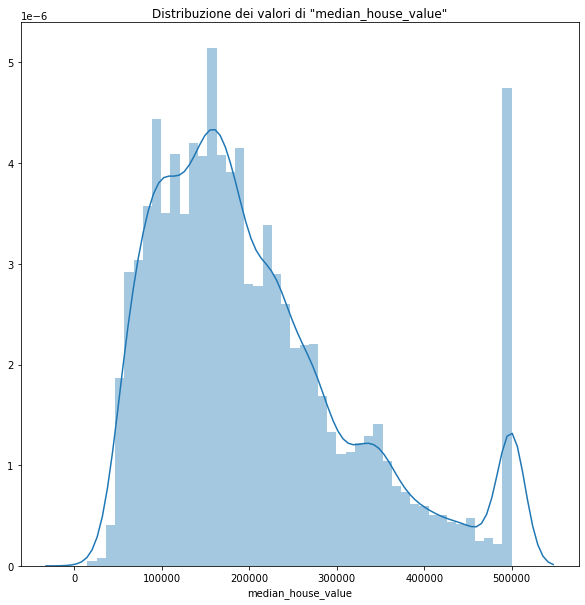

In [1087]:
plt.figure(figsize=(10, 10))
plt.title('Distribuzione dei valori di "median_house_value"')
seaborn.distplot(data_frame[column_to_predict])
plt.show()

## Ottimizzazione banca dati
### Gestione delle celle vuote

Riempe le celle vuote con la media

In [1088]:
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)


### Gestione delle colonna categoria "ocean_proximity"
Genera le colonne per ogni elemento di una colonna categoria

In [1089]:
columns_categories = pandas.DataFrame()

for c in categories_columns:
    column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')
    columns_categories = pandas.concat((columns_categories, column), axis=1)

columns_categories


,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,1,0,0,0,0
1,1,0,0,0,0
2,0,0,0,0,1
3,0,0,0,0,1
4,0,1,0,0,0
...,...,...,...,...,...
20635,1,0,0,0,0
20636,0,1,0,0,0
20637,0,0,0,1,0
20638,1,0,0,0,0


Elimina le colonne categoria e aggiunge le colonne per ogni elemento di una colonna categoria

In [1090]:
data_frame.drop(columns=categories_columns, inplace=True)
data_frame = pandas.concat([data_frame, columns_categories], axis=1)

### Correlazione tra le caratteristiche
Matrice di correlazione tra le caratteristiche

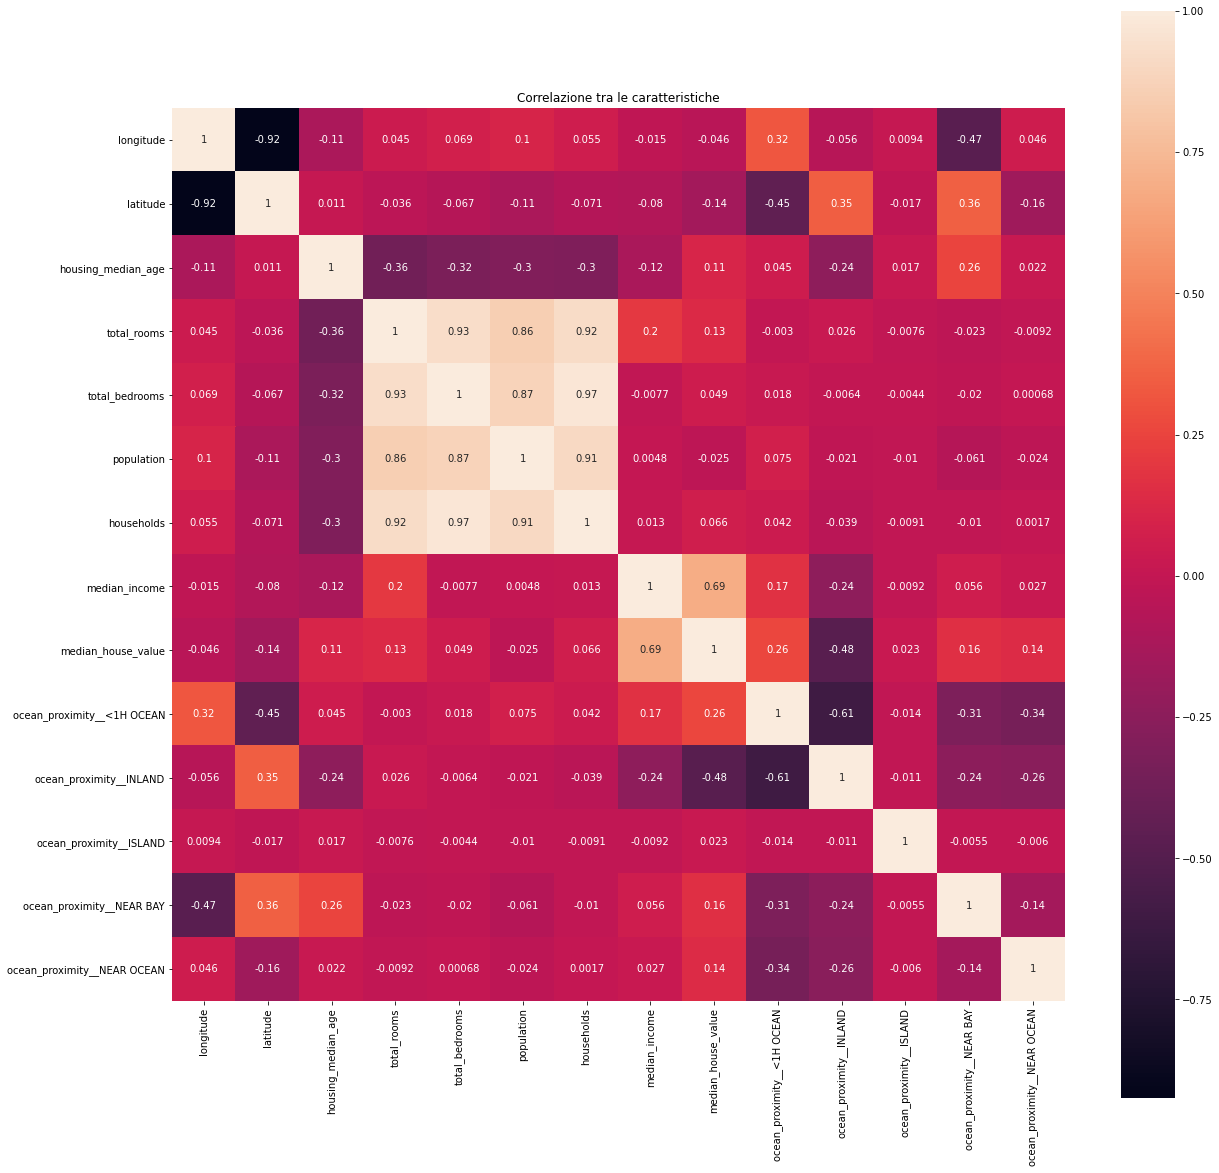

In [1091]:
corr = data_frame.corr()
plt.figure(figsize=(20, 20))
plt.title('Correlazione tra le caratteristiche')
seaborn.heatmap(corr, square=True, annot=True)
plt.show()

Controlliamo quale caratteristica ha una correlazione maggiore di 0,75 (in valore assoluto) con almeno qualche altra caratteristica

In [1092]:
correlated_features = corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1.0)].dropna(axis='index', how='all')
correlated_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
longitude,NaN,-0.924664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.924664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.927253,0.857126,0.918484,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.927253,NaN,0.873910,0.974725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population,NaN,NaN,NaN,0.857126,0.873910,NaN,0.907222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
households,NaN,NaN,NaN,0.918484,0.974725,0.907222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Eliminazione caratteristiche:
1. households che è vincolata a population
2. total_bedrooms che è vincolata a total_rooms

In [1093]:
columns_to_remove = ['households', 'total_bedrooms', column_to_predict]
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)

X = data_frame.drop(columns=columns_to_remove)
y = data_frame[column_to_predict]

## Analisi algoritmo di apprendimento
### Cross-validated risk estimate

In [1094]:
# sostituire con il nostro medoto
learner = Ridge(alpha=0.01, normalize=True)
scores = cross_val_score(learner, X, y, cv=5, scoring=RMS)
print(f'Cross-validated risk estimate: {-scores.mean()}')

Cross-validated risk estimate: 5018171757.223233


### Curva apprendimento

In [1095]:
# records da 1 a 2851, step 550 = 7 punti
sizes = range(1, 3851, 550)

# 5 fold di C.V.
train_size, train_score, val_score = learning_curve(learner, X, y, train_sizes=sizes, cv=5, scoring=RMS)

### Standard deviation
Standard deviation is the most important tool for dispersion measurement in a distribution. Technically, the standard deviation is the square root of the arithmetic mean of the squares of deviations of observations from their mean value.
### Arithmetic Mean
Mean is the measure of central tendency most commonly used. Mean is equal to the sum of all the values of a collection of data divided by the number of values in the data.

In [1096]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

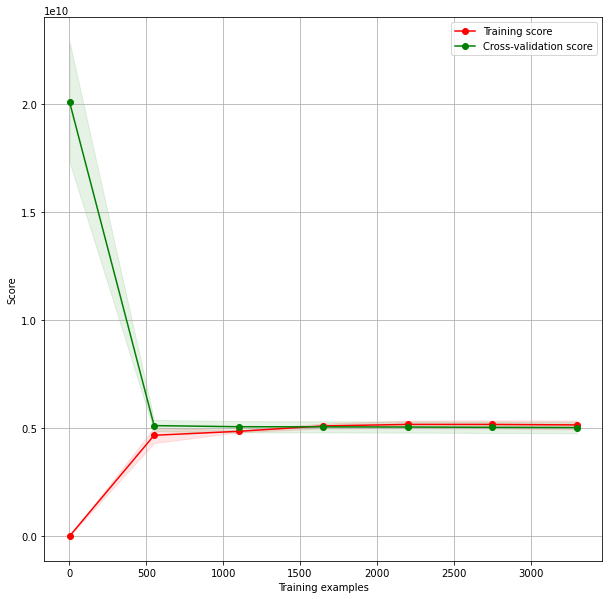

In [1097]:
plt.figure(figsize=(10, 10))
plt.grid()

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, color="r", alpha=0.1)
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, color="g", alpha=0.1)

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training score")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="Cross-validation score")

plt.legend()
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.show()

## Principal Component Analysis
PCA is a method used to reduce number of variables in your data by extracting important one from a large pool. It reduces the dimension of your data with the aim of retaining as much information as possible. In other words, this method combines highly correlated variables together to form a smaller number of an artificial set of variables which is called “principal components” that account for most variance in the data.

In [1098]:
coef_list = []

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=s, shuffle=shuffleDataSet)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = numpy.array(coef_list)

pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

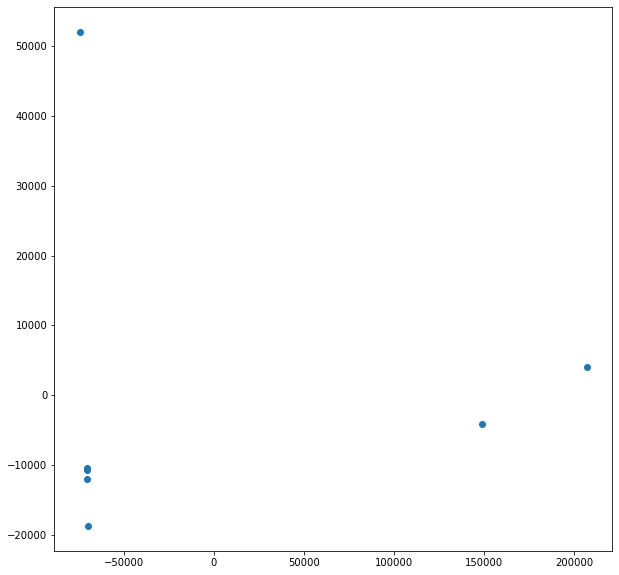

In [1099]:
plt.figure(figsize=(10, 10))
plt.scatter(coef_pca[:, 0], coef_pca[:, 1])


In [1100]:
pca = decomposition.PCA(n_components=X.shape[1])
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=11, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

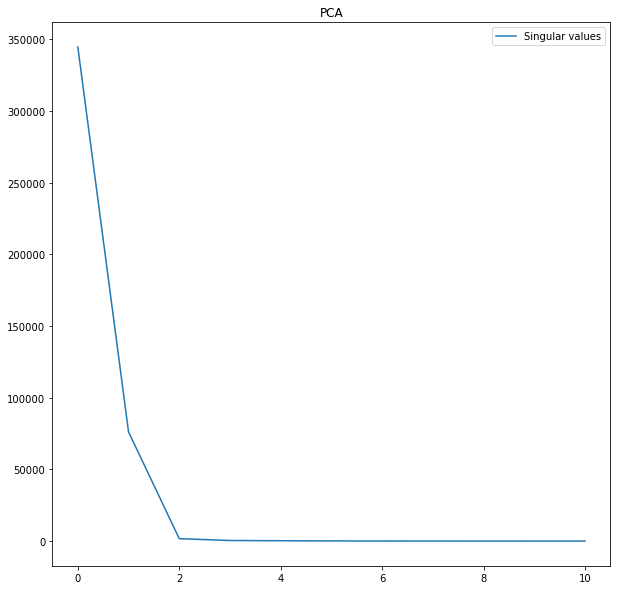

In [1101]:
plt.figure(figsize=(10, 10))
plt.title('PCA')
plt.plot(pca.singular_values_, label='Singular values')
plt.legend()
plt.show()

We project all the datapoints on the principal components. Then we check the learning curve again.

In [1102]:
pca = decomposition.PCA(n_components=4)
pca.fit(X)
X_pca = pca.transform(X)

In [1103]:
X

,longitude,latitude,housing_median_age,total_rooms,population,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-121.75,36.76,32.0,1740.0,1563.0,2.7694,1,0,0,0,0
1,-119.14,34.49,17.0,321.0,92.0,7.7500,1,0,0,0,0
2,-117.04,32.68,14.0,1320.0,943.0,5.0947,0,0,0,0,1
3,-117.11,32.74,33.0,1126.0,621.0,3.2422,0,0,0,0,1
4,-116.62,34.23,14.0,6438.0,1586.0,1.6136,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20635,-118.26,33.97,44.0,1246.0,1031.0,1.9556,1,0,0,0,0
20636,-116.45,33.78,16.0,5228.0,1177.0,3.0859,0,1,0,0,0
20637,-122.03,37.56,24.0,8444.0,4446.0,4.6978,0,0,0,1,0
20638,-118.37,33.97,41.0,1833.0,847.0,5.7260,1,0,0,0,0


In [1104]:
X_pca.shape

(20640, 4)

In [1105]:
X_pca

array([[-7.51010284e+02,  5.07244745e+02,  1.24132669e+00,
         2.57417614e+00],
       [-2.66261025e+03, -2.16017182e+02, -1.63262756e+01,
        -1.61397838e+00],
       [-1.39570174e+03,  1.26262447e+02, -1.74925315e+01,
        -3.74760280e+00],
       ...,
       [ 6.54199991e+03,  2.47749483e+02,  7.27954581e+00,
         3.61477643e+00],
       [-9.73025501e+02, -1.79779379e+02,  1.07744285e+01,
        -2.55406780e+00],
       [ 7.67929165e+02, -2.78482162e+02, -1.48170483e+01,
        -1.81915625e+00]])

In [1106]:
# 5 fold di C.V.
train_size, train_score, val_score = learning_curve(learner, X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)

In [1107]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

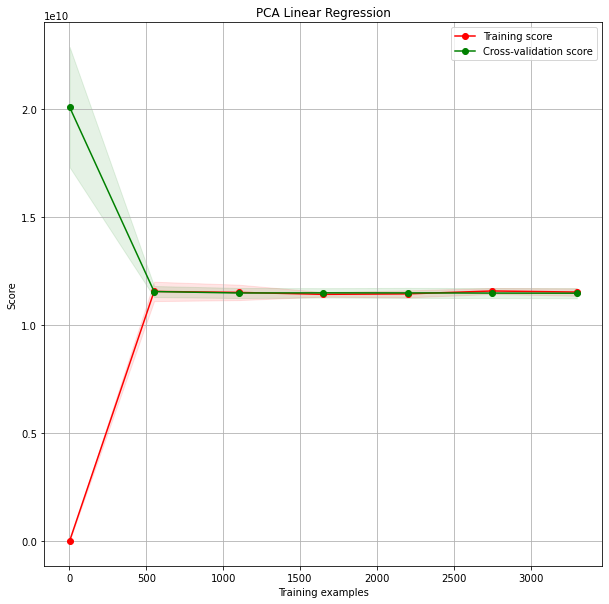

In [1108]:
plt.figure(figsize=(10, 10))
plt.title('PCA Linear Regression')
plt.grid()

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, color="r", alpha=0.1)
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, color="g", alpha=0.1)

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training score")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="Cross-validation score")

plt.legend()
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.show()

In [1109]:
coef_list = []

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=s, shuffle=shuffleDataSet)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = numpy.array(coef_list)

In [1110]:
pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

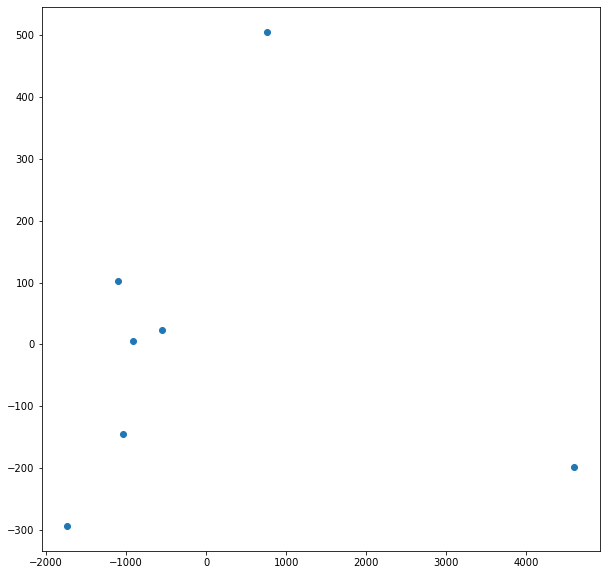

In [1111]:
plt.figure(figsize=(10, 10))
plt.scatter(coef_pca[:,0], coef_pca[:,1])
plt.show()

## Parte Solo Ridge Regression

In [1112]:
alpha_vals = numpy.linspace(0.01, 2.0, 20)
train_score, val_score = validation_curve(Ridge(alpha=0.01, normalize=True), X, y, 'alpha', alpha_vals, cv=5, scoring=RMS)

In [1113]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

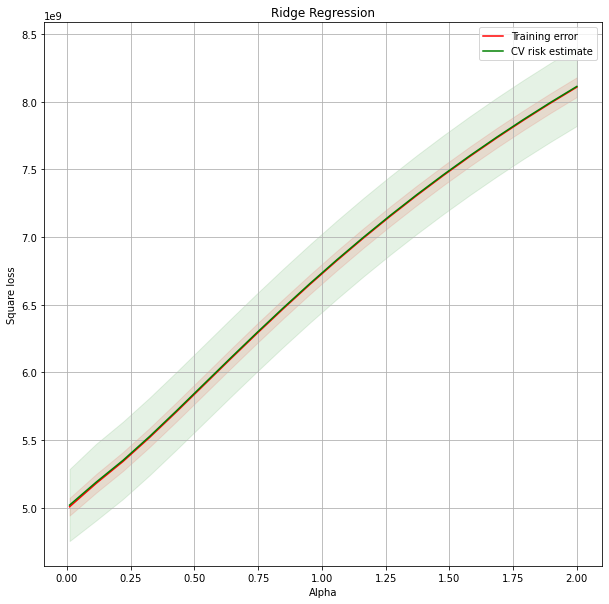

In [1114]:
plt.figure(figsize=(10, 10))
plt.title('Ridge Regression')
plt.grid()

plt.fill_between(alpha_vals, train_score_mean - train_score_std, train_score_mean + train_score_std, alpha=0.1, color="r")
plt.fill_between(alpha_vals, val_score_mean - val_score_std, val_score_mean + val_score_std, alpha=0.1, color="g")

plt.plot(alpha_vals, train_score_mean, color="r", label="Training error")
plt.plot(alpha_vals, val_score_mean, color="g", label="CV risk estimate")

plt.xlabel('Alpha')
plt.ylabel('Square loss')
plt.legend()
plt.show()

In [1115]:
l_train_size, l_train_score, l_val_score = learning_curve(LinearRegression(normalize=True), X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)
r_train_size, r_train_score, r_val_score = learning_curve(Ridge(alpha=0.01, normalize=True), X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)

In [1116]:
l_val_score_mean = -numpy.mean(l_val_score, axis=1)
l_val_score_std = numpy.std(l_val_score, axis=1)
r_val_score_mean = -numpy.mean(r_val_score, axis=1)
r_val_score_std = numpy.std(r_val_score, axis=1)

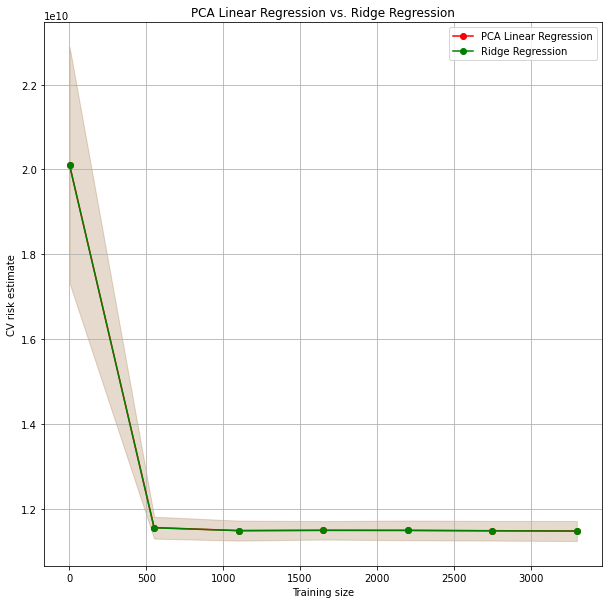

In [1117]:
plt.figure(figsize=(10, 10))
plt.title('PCA Linear Regression vs. Ridge Regression')
plt.grid()

plt.fill_between(sizes, l_val_score_mean - l_val_score_std, l_val_score_mean + l_val_score_std, alpha=0.1, color="r")
plt.fill_between(sizes, r_val_score_mean - r_val_score_std, r_val_score_mean + r_val_score_std, alpha=0.1, color="g")

plt.plot(sizes, l_val_score_mean, 'o-', color="r", label="PCA Linear Regression")
plt.plot(sizes, r_val_score_mean, 'o-', color="g", label="Ridge Regression")

plt.xlabel('Training size')
plt.ylabel('CV risk estimate')
plt.legend()
plt.show()